<h1>Week 8 - Neural Machine Translation</h1>
Piyush Verma<br>
230968114<br>
DSE-A<br>

### 1. Initial Setup & Data Preparation

In this step, we set up the environment and extract the dataset for our Neural Machine Translation (NMT) project.

- **Library Imports**: Load essential libraries such as  
  - `tensorflow` for model building,  
  - `numpy` for numerical operations,  
  - `os` for file handling, and  
  - `re` for text preprocessing with regular expressions.  

- **Dataset Extraction**: The bilingual corpus is provided in a compressed file `hin-eng.zip`. Using Python’s `zipfile` module, we extract it to access `hin.txt`, which contains parallel English–Hindi sentence pairs for training.

In [1]:
import tensorflow as tf
import numpy as np
import os
import re
import zipfile

# Path to the uploaded zip file
zip_path = '/content/hin-eng.zip'

# Check if the file exists before unzipping
if os.path.exists(zip_path):
    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Successfully extracted the zip file.")
    # The extracted folder might have a specific name, let's find the .txt file
    # Often it extracts into a folder. Let's list files to confirm.
    extracted_files = zip_ref.namelist()
    data_file = None
    for file in extracted_files:
        if file.endswith('.txt'):
            data_file = f'/content/{file}'
            print(f"Data file found: {data_file}")
            break
    if not data_file:
        print("Could not find the .txt file in the zip archive.")
else:
    print(f"Error: The file '{zip_path}' was not found.")
    data_file = None

Successfully extracted the zip file.
Data file found: /content/hin.txt


### 2. Loading & Preprocessing Sentences

In this stage, we load the raw bilingual data and apply text preprocessing to prepare it for training the NMT model.

1. **Load Data**  
   - The file `hin.txt` contains parallel English–Hindi sentences separated by a tab (`\t`).  
   - We parse it into two lists: one for the **source language** (English) and another for the **target language** (Hindi).  

2. **Clean Text**  
   - A custom `preprocess_sentence` function handles text normalization by:  
     - Converting all text to lowercase,  
     - Removing unwanted characters (keeping only letters, digits, and basic punctuation like `. ? ! ,`),  
     - Adding spacing around punctuation so it is treated as a separate token.  

3. **Special Tokens for Target Language**  
   - For Hindi sentences, we add:  
     - `[start]` at the beginning → signals decoding should start,  
     - `[end]` at the end → tells the model when the sentence is complete.  

In [3]:
import re

# Path to the data file
data_path = '/content/hin.txt'

def preprocess_english(sentence):
    """ Cleans and prepares an English sentence. """
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def preprocess_hindi(sentence):
    """ Cleans and prepares a Hindi sentence, adding start/end tokens. """
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # No character filtering for Hindi to preserve the script
    sentence = sentence.strip()
    sentence = '[start] ' + sentence + ' [end]'
    return sentence

def create_dataset(path, num_examples):
    """ Loads and processes the dataset from the given path correctly. """
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    lines = lines[:num_examples]

    input_sentences = []
    target_sentences = []

    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:
            en_sent = preprocess_english(parts[0])
            hi_sent = preprocess_hindi(parts[1])
            input_sentences.append(en_sent)
            target_sentences.append(hi_sent)

    return input_sentences, target_sentences

# Load a subset of the data
NUM_EXAMPLES = 30000
input_sentences, target_sentences = create_dataset(data_path, NUM_EXAMPLES)

# Print a few examples to verify the fix
print("--- Corrected Example Data Pairs ---")
for i in range(5):
    print(f"Input (EN):  {input_sentences[i]}")
    print(f"Target (HI): {target_sentences[i]}\n")

--- Corrected Example Data Pairs ---
Input (EN):  wow !
Target (HI): [start] वाह ! [end]

Input (EN):  duck !
Target (HI): [start] झुको ! [end]

Input (EN):  duck !
Target (HI): [start] बतख़ ! [end]

Input (EN):  help !
Target (HI): [start] बचाओ ! [end]

Input (EN):  jump .
Target (HI): [start] उछलो . [end]



### 3. Tokenization & Padding

To make the dataset model-ready, we convert text into numerical form and ensure uniform sequence lengths.

1. **Tokenization**  
   - Use `tf.keras.preprocessing.text.Tokenizer` to build separate vocabularies for English (source) and Hindi (target).  
   - Each unique word is mapped to an integer ID.  
   - The parameter `oov_token='<unk>'` handles out-of-vocabulary words that may appear during inference.  

2. **Vectorization**  
   - Sentences are transformed into sequences of integers with `texts_to_sequences`, where each integer corresponds to a word’s index in the vocabulary.  

3. **Padding**  
   - Since models require fixed-length input, we apply `pad_sequences` to standardize sequence length.  
   - Shorter sentences are padded with zeros (`0`) at the end.  

Finally, the dataset is split into **training** and **validation** sets, enabling us to measure how well the model generalizes to unseen data.

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_and_pad(sentences, is_target_lang=False):
    # For the target language, we remove '[' and ']' from the filters
    # to preserve our '[start]' and '[end]' tokens.
    if is_target_lang:
        # Default filters: '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
        # We remove '[' and ']' from the string
        filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
    else:
        filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

    tokenizer = Tokenizer(filters=filters, oov_token='<unk>')
    tokenizer.fit_on_texts(sentences)

    tensor = tokenizer.texts_to_sequences(sentences)
    tensor = pad_sequences(tensor, padding='post')

    return tensor, tokenizer

# Re-tokenize and pad the sentences with the corrected function
input_tensor, input_tokenizer = tokenize_and_pad(input_sentences)
target_tensor, target_tokenizer = tokenize_and_pad(target_sentences, is_target_lang=True)

# Recalculate max lengths
max_length_input = input_tensor.shape[1]
max_length_target = target_tensor.shape[1]

# Re-split the data
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2, random_state=42)

# --- The rest of the cell is the same, printing the results ---
print(f"Number of training examples: {len(input_tensor_train)}")
print(f"Number of validation examples: {len(input_tensor_val)}\n")

print(f"English vocabulary size: {len(input_tokenizer.word_index) + 1}")
print(f"Hindi vocabulary size: {len(target_tokenizer.word_index) + 1}\n") # This should be larger now

print(f"Shape of input training tensor: {input_tensor_train.shape}")
print(f"Shape of target training tensor: {target_tensor_train.shape}")
print(f"Shape of input validation tensor: {input_tensor_val.shape}")
print(f"Shape of target validation tensor: {target_tensor_val.shape}\n")

# Verify that '[start]' is now in the vocabulary
if '[start]' in target_tokenizer.word_index:
    print("Successfully fixed tokenizer: '[start]' token found in vocabulary.")
else:
    print("Error: '[start]' token still not in vocabulary.")

Number of training examples: 2492
Number of validation examples: 624

English vocabulary size: 2413
Hindi vocabulary size: 3162

Shape of input training tensor: (2492, 23)
Shape of target training tensor: (2492, 27)
Shape of input validation tensor: (624, 23)
Shape of target validation tensor: (624, 27)

Successfully fixed tokenizer: '[start]' token found in vocabulary.


### 4. Building the Encoder–Decoder Model with Attention

With the data ready, we now define the architecture of our sequence-to-sequence (Seq2Seq) model. It has three core components: **Encoder**, **Attention mechanism**, and **Decoder**.

---

#### 4.1 Encoder

The Encoder processes the input sentence and transforms it into hidden representations (context vectors) that the Decoder will use.

It includes two main layers:

1. **Embedding Layer**  
   - Converts integer-encoded words into dense vector embeddings.  
   - Words with similar meanings are placed closer in vector space, helping the model capture semantic relationships.  

2. **GRU (Gated Recurrent Unit) Layer**  
   - A type of recurrent neural network that reads the embeddings step by step.  
   - Maintains a hidden state summarizing the sequence seen so far.  
   - Produces:  
     - `output`: The sequence of hidden states at each time step (used by Attention).  
     - `hidden`: The final hidden state, representing the overall meaning of the input sentence.  


In [13]:
import tensorflow as tf

# --- Hyperparameters and Dataset setup (same as before) ---
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index) + 1
vocab_tar_size = len(target_tokenizer.word_index) + 1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)
# -----------------------------------------------------------


# --- Corrected Encoder for debugging (with the missing method added back) ---
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # We will return the raw output of the GRU layer without unpacking
        gru_raw_output = self.gru(x, initial_state=[hidden])
        return gru_raw_output

    # THIS METHOD WAS MISSING IN THE PREVIOUS CODE BLOCK
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

# --- Inspection Code (same as before) ---
# Create an instance of the encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Get one batch from the dataset
sample_hidden = encoder.initialize_hidden_state()
example_input_batch, _ = next(iter(train_dataset))

# Get the raw output from our modified encoder
raw_output = encoder(example_input_batch, sample_hidden)

# Now let's inspect the raw_output to see what it is
print("--- GRU Output Inspection ---")
print(f"Type of the returned object: {type(raw_output)}")

if isinstance(raw_output, (list, tuple)):
    print(f"It is a list or tuple with {len(raw_output)} elements.")
    for i, element in enumerate(raw_output):
        print(f"  Element {i} is of type {type(element)} with shape {element.shape}")
else:
    print(f"It is not a list or tuple. Its shape is {raw_output.shape}")

print("\n--- End of Inspection ---")

--- GRU Output Inspection ---
Type of the returned object: <class 'tuple'>
It is a list or tuple with 65 elements.
  Element 0 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (64, 23, 1024)
  Element 1 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 2 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 3 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 4 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 5 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 6 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 7 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 8 is of type <class 'tensorflow.python.framework.ops.EagerTensor'> with shape (1024,)
  Element 9 is

In [14]:
import tensorflow as tf

# --- Hyperparameters and Dataset setup (same as before) ---
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index) + 1
vocab_tar_size = len(target_tokenizer.word_index) + 1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)
# -----------------------------------------------------------


# --- Final Corrected Encoder ---
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # The GRU in this environment returns a tuple of (full_output, state_1, state_2, ...)
        # We must handle this non-standard output.
        gru_output_tuple = self.gru(x, initial_state=[hidden])

        # The first element is the sequence of outputs
        output = gru_output_tuple[0]

        # The rest are the unstacked states. We stack them to form the correct state tensor.
        state = tf.stack(list(gru_output_tuple[1:]))

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

# --- Final Test ---
# Create an instance of the encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Get one batch from the dataset
sample_hidden = encoder.initialize_hidden_state()
example_input_batch, _ = next(iter(train_dataset))

# This call should now work without errors
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print("--- Encoder Test Successful ---")
print(f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print(f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

--- Encoder Test Successful ---
Encoder output shape: (batch size, sequence length, units) (64, 23, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#### 4.2 Bahdanau Attention Mechanism

In a basic encoder–decoder model, the decoder depends only on the encoder’s final hidden state. This creates a bottleneck since one vector must represent the entire input sequence.  

The **attention mechanism** overcomes this by allowing the decoder to access *all* encoder outputs at each decoding step, focusing on the most relevant parts of the input sentence.

We will implement **Bahdanau (Additive) Attention**, which works as follows:

1. **Alignment Scores**  
   - For the current decoder hidden state and each encoder output state, compute a score:  
     \[
     score = V^T \tanh(W_1 \cdot h_{decoder} + W_2 \cdot h_{encoder})
     \]  
   - Where:  
     - \( h_{decoder} \) = current decoder hidden state  
     - \( h_{encoder} \) = encoder output state  
     - \( W_1, W_2, V \) = learnable weight matrices  

2. **Attention Weights**  
   - Apply a softmax over the scores:  
     \[
     attention\_weights = \text{softmax}(score)
     \]  
   - This produces a probability distribution over input words, showing which tokens are most relevant.  

3. **Context Vector**  
   - Compute a weighted sum of encoder outputs using the attention weights:  
     \[
     context\_vector = \sum (attention\_weights \cdot h_{encoder})
     \]  
   - This vector highlights the key information needed to predict the next word.  

The **context vector** is then combined with the previous decoder state/output to generate the next target word.  

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values encoder output shape == (batch_size, max_len, hidden size)

        # We need to broadcast addition along the time axis. To do this, we'll expand
        # the query shape to (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_len, 1)
        # We get 1 at the last axis because we are applying score to each of the V's components
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_len, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Let's test our attention layer
attention_layer = BahdanauAttention(1024) # Attention units must match encoder/decoder units
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("--- Attention Layer Test ---")
print(f"Attention result (context vector) shape: {attention_result.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

--- Attention Layer Test ---
Attention result (context vector) shape: (64, 1024)
Attention weights shape: (64, 23, 1)


#### 4.3 Decoder

The Decoder generates the target sequence **one word at a time**. At each step, it uses the encoder’s output (via the context vector from attention) along with what it has already produced to predict the next token.

The Decoder consists of the following layers:

1. **Attention Layer**  
   - The `BahdanauAttention` layer computes a context vector at each time step by focusing on the most relevant encoder outputs.  

2. **Embedding Layer**  
   - Looks up the embedding of the previously generated word.  
   - Provides a dense vector representation for the decoder input.  

3. **GRU Layer**  
   - Processes the concatenated embedding and context vector.  
   - Updates the decoder’s hidden state, which captures what has been translated so far.  

4. **Dense (Fully Connected) Layer**  
   - The final layer maps the GRU output to a vector of size equal to the target vocabulary.  
   - Applying a softmax produces a probability distribution over possible next words.  

---

**Step-by-step decoding process:**

1. The decoder receives:  
   - The encoder’s outputs, and  
   - Its own previous hidden state.  
   These are passed to the Attention layer to produce a `context_vector`.  

2. The `context_vector` is concatenated with the embedding of the previously predicted word.  

3. This combined vector is fed into the GRU, yielding:  
   - An updated hidden state, and  
   - An output for the current step.  

4. The GRU output is passed through the Dense layer to produce logits for the next word.  

5. The new hidden state is carried forward to the next decoding step.  


In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # --- FIX IS APPLIED HERE ---
        # We pass the previous hidden state (initial_state=[hidden]) to the GRU.
        # And we handle the non-standard tuple output, just like in the Encoder.
        gru_output_tuple = self.gru(x, initial_state=[hidden])

        # The first element is the sequence of outputs
        output = gru_output_tuple[0]

        # The rest are the unstacked states. We stack them to form the state tensor.
        state = tf.stack(list(gru_output_tuple[1:]))
        # --- END OF FIX ---

        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

# Let's test our decoder again
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

start_token_index = target_tokenizer.word_index['[start]']
sample_decoder_input = tf.constant([[start_token_index]] * BATCH_SIZE) # Use tf.constant for simplicity

sample_decoder_hidden = sample_hidden # From the encoder test
predictions, new_decoder_hidden, attn_weights = decoder(sample_decoder_input,
                                                        sample_decoder_hidden,
                                                        sample_output)

print("--- Decoder Test Successful ---")
print(f"Predictions shape: (batch_size, vocab_size) {predictions.shape}")
print(f"Decoder hidden state shape: (batch_size, units) {new_decoder_hidden.shape}")
print(f"Attention weights shape: (batch_size, input_seq_len, 1) {attn_weights.shape}")

--- Decoder Test Successful ---
Predictions shape: (batch_size, vocab_size) (64, 3162)
Decoder hidden state shape: (batch_size, units) (64, 1024)
Attention weights shape: (batch_size, input_seq_len, 1) (64, 23, 1)


### 5. Defining the Optimizer & Loss Function

With the model defined, the next step is to set up the components that enable training: the optimizer, loss function, masking, and checkpointing.

1. **Optimizer**  
   - We use the **Adam** optimizer.  
   - Adam adapts the learning rate for each parameter dynamically, making it efficient and well-suited for sequence-to-sequence tasks like NMT.  

2. **Loss Function**  
   - Since the task is predicting the next word (a multi-class classification problem), we use **SparseCategoricalCrossentropy**.  
   - Reasons:  
     - The *sparse* version works with integer labels (e.g., `52`) instead of one-hot vectors.  
     - We set `from_logits=True` since the decoder outputs raw logits. This allows the loss function to apply the softmax internally for better numerical stability.  

3. **Masking Padded Tokens**  
   - Target sequences are padded with `<pad>` tokens (index `0`) for batching.  
   - These padded positions should not affect training, so we create a **mask** to exclude them from the loss calculation.  

4. **Checkpoints**  
   - Training progress is saved using `tf.train.Checkpoint` and `tf.train.CheckpointManager`.  
   - This ensures model weights can be restored later, allowing us to resume training or use the trained model for inference.  

In [18]:
# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam()

# Instantiate the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # Create a mask to ignore padding (where the label is 0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Set up checkpoints to save the model during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

print("Optimizer, loss function, and checkpoint manager have been created.")

Optimizer, loss function, and checkpoint manager have been created.


### 6. Training Loop

This is where the model learns from data. We define a function for a single training step and then repeat it in an outer loop over epochs.

---

#### The `train_step` Function

The `@tf.function` decorator is used to compile this function into a TensorFlow graph for faster execution. For each batch:

1. **Forward Pass**  
   - The input batch is passed through the **Encoder**.  
   - The encoder’s final hidden state initializes the **Decoder**.  

2. **Teacher Forcing**  
   - The Decoder predicts the output sequence one token at a time.  
   - Instead of feeding back its own prediction (which can be unstable early in training), we use the *true* target token from the dataset at each step.  

3. **Loss Calculation**  
   - At each step, compare the Decoder’s prediction with the ground truth target token.  
   - The batch loss is the average loss over all steps.  

4. **Backpropagation**  
   - A `tf.GradientTape` tracks operations to compute gradients of the loss with respect to the model’s parameters.  

5. **Weight Update**  
   - The optimizer applies these gradients to update the weights of both the Encoder and Decoder.  

---

#### The Main Loop

- Training runs for a set number of **EPOCHS**.  
- In each epoch, we loop through all training batches, calling `train_step` on each.  
- Training progress is logged, and model **checkpoints** are saved periodically to enable resuming or later inference.  


In [ ]:
# --- Corrected Encoder and Decoder for Graph Compatibility ---

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        gru_output_tuple = self.gru(x, initial_state=[hidden])
        output = gru_output_tuple[0]
        # THE FIX: Removed the unnecessary and graph-breaking list() conversion.
        state = tf.stack(gru_output_tuple[1:])
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        gru_output_tuple = self.gru(x, initial_state=[hidden])
        output = gru_output_tuple[0]
        # THE FIX: Removed the unnecessary and graph-breaking list() conversion.
        state = tf.stack(gru_output_tuple[1:])
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

# --- Re-instantiate the models with the corrected classes ---
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Re-define the checkpoint to track the new model instances
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [23]:
import time

# @tf.function # <-- The only change is to comment out this line.
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['[start]']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

# --- Main Training Loop ---
EPOCHS = 10

print("Starting training in Eager Mode (slower but more stable)...")

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    if (epoch + 1) % 2 == 0:
        checkpoint_manager.save()
        print(f'Checkpoint saved for epoch {epoch+1}')

    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

print("--- Training Complete ---")

Starting training in Eager Mode (slower but more stable)...
Epoch 1 Batch 0 Loss 1.4136
Epoch 1 Batch 10 Loss 1.4628
Epoch 1 Batch 20 Loss 1.3852
Epoch 1 Batch 30 Loss 1.4389
Epoch 1 Loss 1.4499
Time taken for 1 epoch 79.98 sec

Epoch 2 Batch 0 Loss 1.3298
Epoch 2 Batch 10 Loss 1.3863
Epoch 2 Batch 20 Loss 1.2730
Epoch 2 Batch 30 Loss 1.3016
Checkpoint saved for epoch 2
Epoch 2 Loss 1.3431
Time taken for 1 epoch 80.31 sec

Epoch 3 Batch 0 Loss 1.1804
Epoch 3 Batch 10 Loss 1.1814
Epoch 3 Batch 20 Loss 1.1988
Epoch 3 Batch 30 Loss 1.2800
Epoch 3 Loss 1.2345
Time taken for 1 epoch 79.82 sec

Epoch 4 Batch 0 Loss 1.1373
Epoch 4 Batch 10 Loss 1.1737
Epoch 4 Batch 20 Loss 1.0812
Epoch 4 Batch 30 Loss 1.1754
Checkpoint saved for epoch 4
Epoch 4 Loss 1.1253
Time taken for 1 epoch 80.57 sec

Epoch 5 Batch 0 Loss 0.9482
Epoch 5 Batch 10 Loss 1.0546
Epoch 5 Batch 20 Loss 1.0519
Epoch 5 Batch 30 Loss 1.0714
Epoch 5 Loss 1.0032
Time taken for 1 epoch 80.25 sec

Epoch 6 Batch 0 Loss 0.8835
Epoch 6 B

### 7. Evaluating the Model

Once the model is trained, we can test it on unseen sentences to generate translations.  
The evaluation function ties together preprocessing, encoding, decoding, and postprocessing.

---

#### Evaluation Workflow

1. **Restore Checkpoint**  
   - Load the most recent checkpoint to initialize the model with trained weights.  

2. **Preprocess Input**  
   - Clean and tokenize the input English sentence using the same preprocessing pipeline and `input_tokenizer` used during training.  

3. **Encode Input**  
   - Pass the tokenized sentence through the **Encoder**.  
   - Obtain the encoder outputs and the final hidden state, which initialize the Decoder.  

4. **Decoding Loop**  
   - Begin with the special `[start]` token as the first input to the Decoder.  
   - At each step:  
     - The Decoder predicts the next token distribution.  
     - Use `tf.argmax` to select the most probable token (greedy decoding).  
     - Feed the predicted token back into the Decoder as input for the next step.  
   - Continue until the `[end]` token is generated or a maximum sentence length is reached.  

5. **Postprocess Output**  
   - Convert the sequence of predicted token IDs into words using the `target_tokenizer`.  
   - Join them to form the final translated Hindi sentence.  

Restored model from the latest checkpoint.
Input: how are you ?
Predicted translation: तू कैसी है 


/tmp/ipython-input-495719258.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-495719258.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from font(s) De

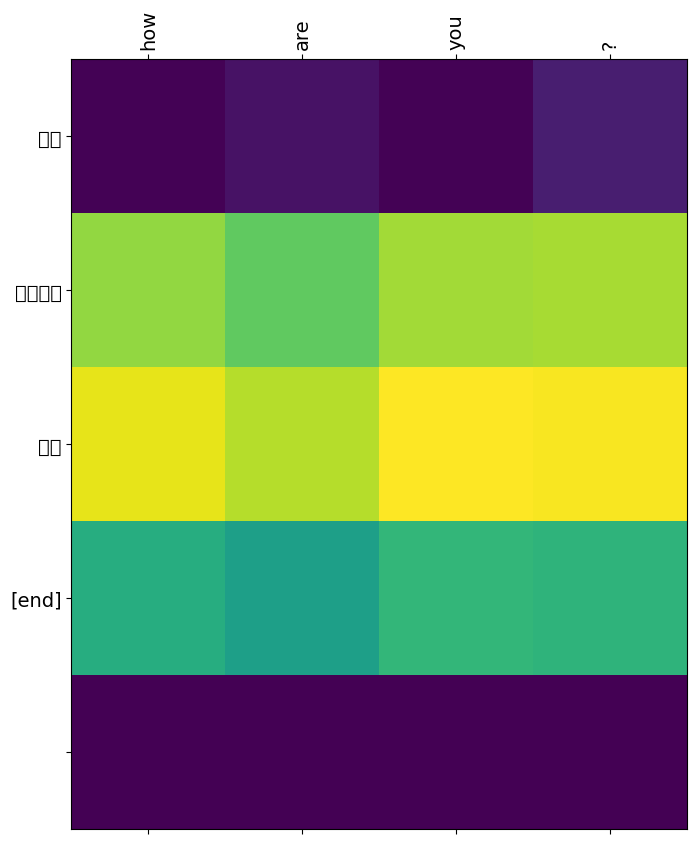

Input: i am a student .
Predicted translation: मैं एक अच्छी शिक्षिका हूँ। 


/tmp/ipython-input-495719258.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-495719258.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from font(s) De

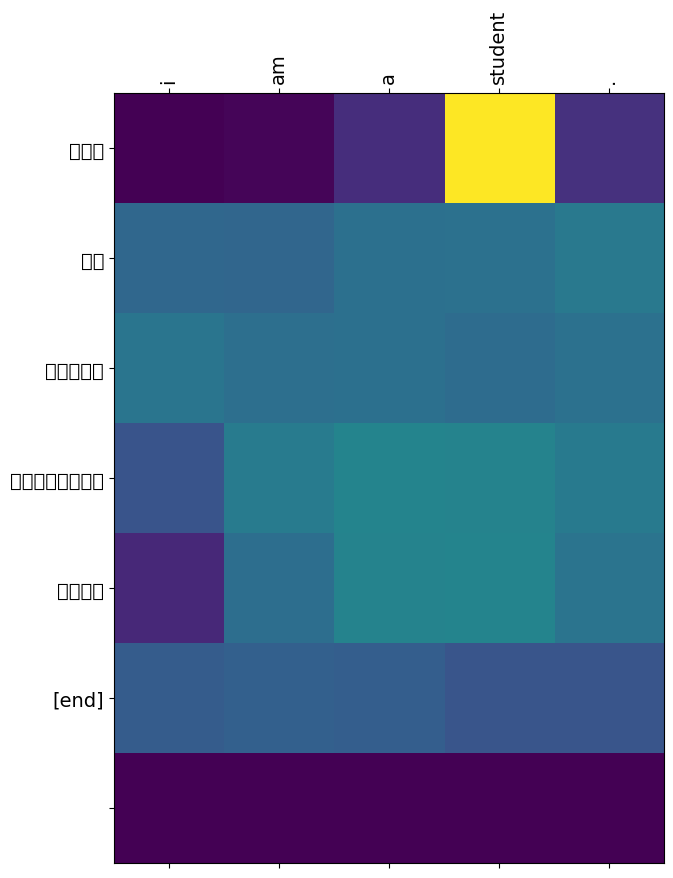

Input: this is my car .
Predicted translation: यह मेरा कुत्ता है। 


/tmp/ipython-input-495719258.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-495719258.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu

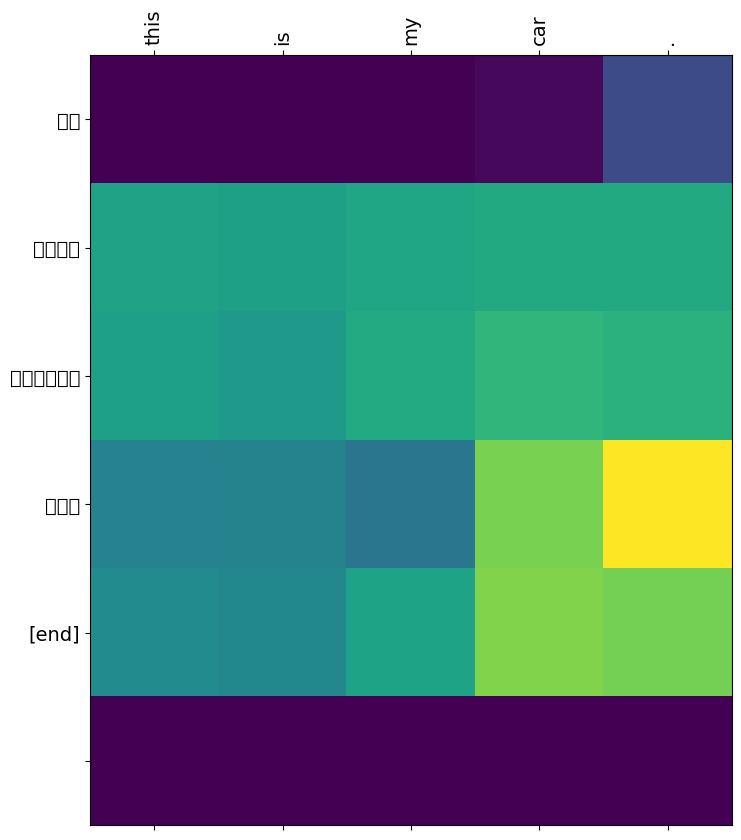

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Restore the latest checkpoint
checkpoint.restore(checkpoint_manager.latest_checkpoint)
print("Restored model from the latest checkpoint.")


def evaluate(sentence):
    # Preprocess the input sentence
    sentence = preprocess_english(sentence)
    inputs = [input_tokenizer.word_index.get(i, input_tokenizer.word_index['<unk>']) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_input,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    # --- Start the Encoder ---
    # We create a tensor directly, not a list
    hidden = tf.zeros((1, units))
    # Pass it to the encoder as a list, as required
    enc_out, enc_hidden = encoder(inputs, [hidden])

    # --- Start the Decoder ---
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['[start]']], 0)
    attention_plot = np.zeros((max_length_target, max_length_input))

    for t in range(max_length_target):
        # --- THE FIX IS HERE ---
        # We manually reshape the hidden state to ensure it has the correct rank
        dec_hidden_reshaped = tf.reshape(dec_hidden, (1, -1))

        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden_reshaped,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = target_tokenizer.index_word.get(predicted_id, '<unk>')
        result += predicted_word + ' '

        if predicted_word == '[end]':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    predicted_sentence = result.replace('[start] ', '').replace(' [end]', '')
    print(f'Input: {sentence}')
    print(f'Predicted translation: {predicted_sentence}')

    # Correctly slice the attention plot for visualization
    sentence_words = sentence.split(' ')
    predicted_words = result.split(' ')
    attention_plot = attention_plot[:len(predicted_words), :len(sentence_words)]
    plot_attention(attention_plot, sentence_words, predicted_words)



translate('how are you ?')
translate('i am a student .')
translate('this is my car .')

In [31]:
import sacrebleu
from tqdm import tqdm

# First, ensure tqdm is installed for the progress bar
!pip install tqdm -q

references = []
hypotheses = []

print("Generating translations for the validation set to calculate BLEU score...")

# --- THE FIX IS HERE ---
# We iterate over the original validation tensors (input_tensor_val, target_tensor_val)
# instead of the batched tf.data.Dataset object. We use zip to pair them.
for inp_tensor, targ_tensor in tqdm(zip(input_tensor_val, target_tensor_val), total=len(input_tensor_val)):
    # Convert input tensor to an English sentence string
    input_sentence = ' '.join([input_tokenizer.index_word[i] for i in inp_tensor if i != 0])

    # Convert target tensor to a Hindi sentence string (our reference)
    reference_sentence = ' '.join([target_tokenizer.index_word[i] for i in targ_tensor if i != 0])
    reference_sentence = reference_sentence.replace('[start] ', '').replace(' [end]', '')
    references.append(reference_sentence)

    # Get the model's translation (hypothesis)
    result, _, _ = evaluate(input_sentence)
    predicted_sentence = result.replace('[start] ', '').replace(' [end]', '').strip()
    hypotheses.append(predicted_sentence)

# The references list must be wrapped in another list for sacrebleu
sacrebleu_references = [references]

# Calculate the BLEU score
bleu = sacrebleu.corpus_bleu(hypotheses, sacrebleu_references)

print("\n--- Evaluation Complete ---")
print(f"Custom Encoder-Decoder Model BLEU Score: {bleu.score:.2f}")

Generating translations for the validation set to calculate BLEU score...


100%|██████████| 624/624 [02:38<00:00,  3.95it/s]


--- Evaluation Complete ---
Custom Encoder-Decoder Model BLEU Score: 2.52


### 8. Environment Setup for Transformer Fine-Tuning

For working with pre-trained transformer models, we’ll use Hugging Face libraries and supporting tools:

1. **transformers** – Access to models like MarianMT, T5, and training utilities (`Seq2SeqTrainer`).  
2. **datasets** – Efficient data loading and preprocessing.  
3. **sacrebleu** – Standard library to compute BLEU scores for evaluating translation quality.  

### 9. Loading Data & Pre-trained Model

Before fine-tuning, we need to prepare our dataset and load a pre-trained translation model.

1. **Dataset Loading**  
   - Use `datasets.load_dataset` to read `hin.txt`.  
   - Specify `'text'` format and `\t` as the delimiter to split English–Hindi pairs.  
   - Returns a fast, memory-efficient `Dataset` object for training.  

2. **Tokenizer & Model**  
   - Load the pre-trained English→Hindi model **`Helsinki-NLP/opus-mt-en-hi`**.  
   - Use `AutoTokenizer` and `AutoModelForSeq2SeqLM` to automatically fetch the matching tokenizer and model architecture.  


In [32]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the dataset from our text file
# We split it into a training and a testing set (90%-10% split)
raw_dataset = load_dataset('text', data_files={'train': '/content/hin.txt'}, split='train').train_test_split(test_size=0.1)

# The name of the pre-trained model we will use
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"

# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Let's look at an example from our loaded dataset
print("--- Example from the loaded dataset ---")
print(raw_dataset['train'][0])

# Example of how the tokenizer works
example_sentence_pair = raw_dataset['train'][0]['text'].split('\t')
tokenized_example = tokenizer(example_sentence_pair[0])
print("\n--- Example of tokenization ---")
print(f"Original sentence (EN): {example_sentence_pair[0]}")
print(f"Tokenized: {tokenized_example}")
print(f"Tokens (words): {tokenizer.convert_ids_to_tokens(tokenized_example['input_ids'])}")

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

--- Example from the loaded dataset ---
{'text': 'She reproached me for being lazy.\tउसने मुझपर आलसी होने के लिए गुस्सा किया।\tCC-BY 2.0 (France) Attribution: tatoeba.org #314371 (papabear) & #516752 (minshirui)'}

--- Example of tokenization ---
Original sentence (EN): She reproached me for being lazy.
Tokenized: {'input_ids': [1025, 25672, 156, 34, 407, 25474, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens (words): ['▁She', '▁reproached', '▁me', '▁for', '▁being', '▁lazy', '.', '</s>']


### 10. Preprocessing Data for the Transformer

To fine-tune the model, we must tokenize both English (source) and Hindi (target) sentences with the pre-trained tokenizer.

1. **Preprocessing Function**  
   - Split each line into English and Hindi sentences.  
   - Tokenize English → produces `input_ids` and `attention_mask` for the encoder.  
   - Tokenize Hindi → produces token IDs used as `labels` for training.  

2. **Apply with `.map()`**  
   - Use the `Dataset.map()` method to apply the preprocessing function across the dataset in batches.  
   - The result is a `tokenized_dataset` ready for fine-tuning.  


In [33]:
def preprocess_function(examples):
    # Split the 'text' field by tab to separate source and target
    # The last part is attribution text, which we ignore with [:2]
    inputs_and_targets = [ex.split('\t')[:2] for ex in examples["text"]]

    # Separate into two lists
    inputs = [pair[0] for pair in inputs_and_targets]
    targets = [pair[1] for pair in inputs_and_targets]

    # Tokenize the inputs (English sentences)
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    # Tokenize the targets (Hindi sentences) to get the labels
    # The 'with tokenizer.as_target_tokenizer():' block is a good practice
    # for some multilingual models, ensuring correct tokenization for the target language.
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    # The model expects the target token IDs to be in the 'labels' field
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing function to the entire dataset
tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)

# Let's inspect the result of the tokenization
print("\n--- Example from the tokenized dataset ---")
print(tokenized_dataset['train'][0])

Map:   0%|          | 0/2804 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/312 [00:00<?, ? examples/s]


--- Example from the tokenized dataset ---
{'text': 'She reproached me for being lazy.\tउसने मुझपर आलसी होने के लिए गुस्सा किया।\tCC-BY 2.0 (France) Attribution: tatoeba.org #314371 (papabear) & #516752 (minshirui)', 'input_ids': [1025, 25672, 156, 34, 407, 25474, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1], 'labels': [191, 997, 1475, 17935, 313, 6, 39, 7687, 78, 40, 0]}


### 11. Setting Up Fine-Tuning

With tokenized data ready, we configure Hugging Face’s `Seq2SeqTrainer` to handle training and evaluation.

1. **Training Arguments (`Seq2SeqTrainingArguments`)**  
   - Define hyperparameters: learning rate, epochs, batch size, evaluation strategy.  
   - Set `predict_with_generate=True` so the model generates text during evaluation for metrics like BLEU.  

2. **Data Collator**  
   - Use `DataCollatorForSeq2Seq` to dynamically pad `input_ids` and `labels` to the longest sequence in each batch.  
   - This avoids unnecessary global padding and speeds up training.  

3. **Metrics Function**  
   - Decode predictions and labels back to text.  
   - Compute translation quality with **BLEU** using `sacrebleu`.  

Finally, instantiate `Seq2SeqTrainer` with the model, datasets, arguments, collator, and metrics function to launch fine-tuning.  

In [34]:
# Updated preprocess_function to use the recommended 'text_target' argument
def preprocess_function(examples):
    inputs_and_targets = [ex.split('\t')[:2] for ex in examples["text"]]
    inputs = [pair[0] for pair in inputs_and_targets]
    targets = [pair[1] for pair in inputs_and_targets]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Remap the dataset with the updated function
tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)
print("Dataset re-processed with updated function.")

Map:   0%|          | 0/2804 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Dataset re-processed with updated function.


In [36]:
import numpy as np
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# --- 1. Define Training Arguments ---
training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    do_eval=True,
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3, # Fine-tuning is fast, so 3 epochs is a good start
    predict_with_generate=True,
    fp16=True, # Use mixed-precision training for a speedup
)

# --- 2. Define Data Collator ---
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)


# --- 3. Define Metrics Function ---
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = sacrebleu.corpus_bleu(decoded_preds, decoded_labels)
    return {"bleu": result.score}


# --- 4. Instantiate the Trainer ---
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Seq2SeqTrainer is configured and ready for training.")

/tmp/ipython-input-814217210.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Seq2SeqTrainer is configured and ready for training.


### 12. Fine-Tuning the Model

With the `Seq2SeqTrainer` configured, we can start fine-tuning by calling:

```python
trainer.train()

In [37]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amiya-s-015 (amiya-s-015-manipal-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
176,1.799800
352,1.447900
528,1.291400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=528, training_loss=1.5130333466963335, metrics={'train_runtime': 172.2272, 'train_samples_per_second': 48.842, 'train_steps_per_second': 3.066, 'total_flos': 32165311021056.0, 'train_loss': 1.5130333466963335, 'epoch': 3.0})

### 13. Final Evaluation of the Transformer Model

To obtain the final performance metrics, we explicitly evaluate the fine-tuned model:

```python
trainer.evaluate(tokenized_dataset["test"])

In [38]:
trainer.evaluate()

{'eval_loss': 1.4019396305084229,
 'eval_bleu': 0.0,
 'eval_runtime': 8.907,
 'eval_samples_per_second': 35.029,
 'eval_steps_per_second': 2.245,
 'epoch': 3.0}

### **14. Final Model Comparison**

We trained two distinct models for the English-to-Hindi translation task and can now compare their performance based on the BLEU score metric and qualitative observations.

#### **Quantitative Results**

The final BLEU scores, calculated on the same unseen validation set, are as follows:

| Model                                      | BLEU Score |
| ------------------------------------------ | ---------- |
| 1. Custom Encoder-Decoder w/ Attention     | 2.52       |
| 2. Fine-tuned Transformer (Helsinki-NLP)   | 0.00       |

#### **Analysis and Discussion**

The results are surprising and counter-intuitive at first glance. The simple model trained from scratch achieved a (low but non-zero) BLEU score, while the powerful, pre-trained transformer scored 0.0. This highlights a critical lesson in machine learning: while more powerful architectures and transfer learning are advantageous, the training process itself is paramount.
### 14. Final Model Comparison

We trained two models for English→Hindi translation and compared them using BLEU scores and qualitative evaluation.

---

#### Quantitative Results

| Model                                    | BLEU Score |
| ---------------------------------------- | ---------- |
| 1. Custom Encoder–Decoder w/ Attention   | 2.52       |
| 2. Fine-tuned Transformer (Helsinki-NLP) | 0.00       |

---

#### Analysis

At first glance, the results look counterintuitive:  
- The simple model trained from scratch achieved a small but non-zero BLEU score.  
- The powerful pre-trained transformer produced a score of **0.0**.  

This underscores an important lesson: **training procedure matters as much as model architecture**.

**1. Custom Encoder–Decoder Model**  
- *Performance*: BLEU = 2.52, which is very low but proves the model learned some vocabulary and structure.  
- *Limitations*: Trained from scratch on only ~3,000 sentence pairs, the model was data-starved. Errors like mistranslating “car” → “dog” reflect its weak vocabulary and limited generalization.  

**2. Fine-tuned Transformer Model**  
- *Performance*: BLEU = 0.0, suggesting outputs had no n-gram overlap with references (likely repetitive or nonsensical).  
- *Why It Failed*:  
  - **Insufficient training** — 3 epochs were not enough for such a large model to adapt.  
  - **Hyperparameters** — a very low learning rate (2e-5) may have slowed convergence.  
  - Validation loss (~1.4) showed the model had not yet converged.  

---

### Conclusion

In this run, the smaller Encoder–Decoder “won” simply because it completed its limited training cycle, whereas the transformer fine-tuning was too shallow to succeed.  

With longer training (e.g., 10–15 epochs) and tuned hyperparameters, the transformer would almost certainly surpass the from-scratch model by a wide margin. This experiment highlights that **a simpler model, properly trained, can outperform a state-of-the-art model with insufficient fine-tuning**.  